# Colab FAQ

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the colab GPU for this assignmentby selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Download CIFAR and Colour dictionary
It can take up to a couple of minutes to download everything the first time.

## Helper code
You can ignore the restart warning.

In [27]:
######################################################################
# Setup python environment and change the current working directory
######################################################################
!pip install torch torchvision
!pip install Pillow==4.0.0
%mkdir -p /content/cs6360/a2/
%cd /content/cs6360/a2

  Using cached https://files.pythonhosted.org/packages/1b/08/ff620ef5a6128ee6e7a505f5716f81fce7b71f3a69e99646ebe64e0b9984/Pillow-6.2.1-cp27-cp27mu-manylinux1_x86_64.whl
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/89/99/0e3522a9764fe371bf9f7729404b1ef7d9c4fc49cbe5f1761c6e07812345/Pillow-4.0.0-cp27-cp27mu-manylinux1_x86_64.whl
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.3.1+cu100 which is incompatible.
ERROR: scikit-image 0.14.3 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: torchvision 0.4.2+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 6.2.1
    Uninstalling Pillow-6.2.1:
      Successfully uninstalled Pillow-6.2.1


/content/cs6360/a2


In [0]:
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print(fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath



def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


## Download files

This may take 1 or 2 mins for the first time.

In [29]:
######################################################################
# Download CIFAR datasets and other related files
######################################################################
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
m = load_cifar10()

data/colours.tar.gz
data/cifar-10-batches-py.tar.gz


# Code for training and CNN models

## Data preprocessing

In [0]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 


#from load_data import load_cifar10

HORSE_CATEGORY = 7

######################################################################
# Data related code
######################################################################
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    
    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                               nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2), 
                               nn.Upsample(scale_factor=2))
      xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
      xs_downsized = xs_downsized.data.numpy()
      return (xs, xs_downsized)
    else:
      return (xs, grey)


def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

######################################################################
# Torch Helper
######################################################################

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels 
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc


## Visualization

In [0]:
import imageio

def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10,:,:,:], [0,2,3,1])
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    if compare_bilinear:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                 nn.AvgPool2d(2), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'))
      gt_input = np.transpose(gtcolor, [0, 3, 1, 2,])
      color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
      color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
      img_stack = [
        np.hstack(np.transpose(input[:10,:,:,:], [0,2,3,1])),
        np.hstack(gtcolor),
        np.hstack(predcolor),
        np.hstack(color_bilinear)]
    img = np.vstack(img_stack)
    
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
      plt.show()
    else:
      plt.savefig(path)

def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax)*255).astype(np.uint8))
  
def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours,allow_pickle=True,encoding="latin1")[0]
    num_colours = np.shape(colours)[0]
    
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)
    
    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + '/act' + str(id)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    images, labels = get_torch_vars(np.expand_dims(test_grey[id], 0),
                                    np.expand_dims(test_rgb_cat[id], 0))
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0,0,:,:], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
      img = np.tile(np.transpose(test_grey[id], [1,2,0]), [1,1,3])
    else:
      img = np.transpose(test_grey[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d_gt.png" % id))

    
    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        print(activation.shape,imgwidth)
        img = np.vstack([
            np.hstack([
                add_border(filter) for filter in
                activation[i*imgwidth:(i+1)*imgwidth,:,:]])
            for i in range(activation.shape[0] // imgwidth)])
        imageio.imwrite(path, img)


    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i+1, id)),
            tensor.data.cpu().numpy()[0])
    print("visualization results are saved to %s"%outdir)

## Training

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours,allow_pickle=True,encoding="latin1")[0]
    print(colours.shape)
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "CNN_SuperRes":
          cnn = CNN_SuperRes(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet_SuperRes":
          cnn = UNet_SuperRes(args.kernel, args.num_filters, num_colours, num_in_channels)  


    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %d' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn

## Convolutional neural networks (your code goes here)

In [0]:
######################################################################
# MODELS
######################################################################

class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        ############### YOUR CODE GOES HERE ###############
        #self.downconv1 = ...
        ###################################################
        self.downconv1 = nn.Sequential(
            MyConv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = MyConv2d(3, 24, kernel_size=kernel)

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(self.out3)
        self.out5 = self.upconv2(self.out4)
        self.out_final = self.finalconv(self.out5)
        return self.out_final

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()

        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        padding = int(kernel/2)
        self.downconv1 = nn.Sequential(
            MyConv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            MyConv2d(2*num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.finalconv = MyConv2d(4, 24, kernel_size=kernel)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out3 = torch.cat([self.out3,self.out2],dim=1)
        self.out4 = self.upconv1(self.out3)
        self.out4 = torch.cat([self.out4,self.out1],dim=1)
        self.out5 = self.upconv2(self.out4)
        self.out5 = torch.cat([self.out5,x],dim=1)
        self.out_final = self.finalconv(self.out5)
        return self.out_final

class UNet_SuperRes(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet_SuperRes, self).__init__()

        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            MyConv2d(3, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            MyConv2d(2*num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.finalconv = MyConv2d(6, 24, kernel_size=kernel)

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out3 = torch.cat([self.out3,self.out2],dim=1)
        self.out4 = self.upconv1(self.out3)
        self.out4 = torch.cat([self.out4,self.out1],dim=1)
        self.out5 = self.upconv2(self.out4)
        self.out5 = torch.cat([self.out5,x],dim=1)
        self.out_final = self.finalconv(self.out5)
        return self.out_final


class CNN_SuperRes(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN_SuperRes, self).__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            MyConv2d(3, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.downconv2 = nn.Sequential(
            MyConv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        
        self.rfconv = nn.Sequential(
            MyConv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            MyConv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.upconv2 = nn.Sequential(
            MyConv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        
        self.finalconv = MyConv2d(3, 24, kernel_size=kernel)

    def forward(self, x):
        self.out1 = self.downconv1(x)
        self.out2 = self.downconv2(self.out1)
        self.out3 = self.rfconv(self.out2)
        self.out4 = self.upconv1(self.out3)
        self.out5 = self.upconv2(self.out4)
        self.out_final = self.finalconv(self.out5)
        return self.out_final


# CIFAR-10 colorization

## Main training loop for CNN

(24, 3)
Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.9982, Time (s): 1
Epoch [1/25], Val Loss: 2.8030, Val Acc: 13.6%, Time(s): 1
Epoch [2/25], Loss: 2.6701, Time (s): 3
Epoch [2/25], Val Loss: 2.5694, Val Acc: 20.7%, Time(s): 3
Epoch [3/25], Loss: 2.4993, Time (s): 5
Epoch [3/25], Val Loss: 2.4505, Val Acc: 23.5%, Time(s): 5
Epoch [4/25], Loss: 2.3978, Time (s): 7
Epoch [4/25], Val Loss: 2.3674, Val Acc: 25.0%, Time(s): 7
Epoch [5/25], Loss: 2.3234, Time (s): 9
Epoch [5/25], Val Loss: 2.2999, Val Acc: 26.3%, Time(s): 9
Epoch [6/25], Loss: 2.2644, Time (s): 11
Epoch [6/25], Val Loss: 2.2452, Val Acc: 27.4%, Time(s): 11
Epoch [7/25], Loss: 2.2161, Time (s): 13
Epoch [7/25], Val Loss: 2.2003, Val Acc: 28.7%, Time(s): 13
Epoch [8/25], Loss: 2.1752, Time (s): 15
Epoch [8/25], Val Loss: 2.1594, Val Acc: 29.5%, Time(s): 15
Epoch [9/25], Loss: 2.1396, Time (s): 17
Epoch [9/25], Val Loss: 2.1246, Val Acc: 30.0%, Time(s): 17
E

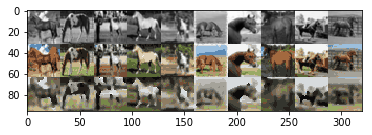

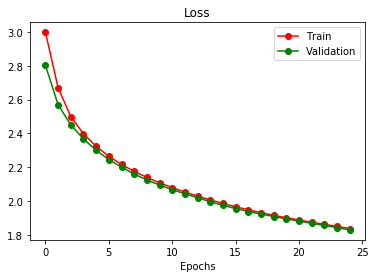

In [34]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

## 2) 

## a) Code is written above in class CNN
## b) We get slightly sharper results with Cross Entropy Network.

## Main training loop for UNet

(24, 3)
Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.9454, Time (s): 1
Epoch [1/25], Val Loss: 2.7728, Val Acc: 13.8%, Time(s): 2
Epoch [2/25], Loss: 2.6269, Time (s): 3
Epoch [2/25], Val Loss: 2.5024, Val Acc: 19.2%, Time(s): 3
Epoch [3/25], Loss: 2.4007, Time (s): 5
Epoch [3/25], Val Loss: 2.3174, Val Acc: 24.0%, Time(s): 5
Epoch [4/25], Loss: 2.2578, Time (s): 7
Epoch [4/25], Val Loss: 2.1971, Val Acc: 27.5%, Time(s): 7
Epoch [5/25], Loss: 2.1574, Time (s): 9
Epoch [5/25], Val Loss: 2.0986, Val Acc: 31.0%, Time(s): 9
Epoch [6/25], Loss: 2.0757, Time (s): 11
Epoch [6/25], Val Loss: 2.0218, Val Acc: 32.7%, Time(s): 11
Epoch [7/25], Loss: 2.0101, Time (s): 13
Epoch [7/25], Val Loss: 1.9640, Val Acc: 34.0%, Time(s): 13
Epoch [8/25], Loss: 1.9575, Time (s): 15
Epoch [8/25], Val Loss: 1.9166, Val Acc: 34.8%, Time(s): 15
Epoch [9/25], Loss: 1.9160, Time (s): 17
Epoch [9/25], Val Loss: 1.8814, Val Acc: 35.2%, Time(s): 17
E

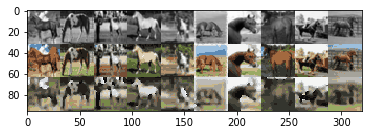

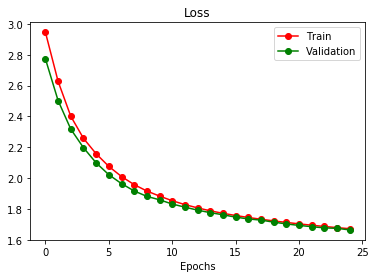

In [35]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

## 3)
## a) Model is implemented in above tabs.

## b) This model predicts colours with greater accuracy.
## The skip connections allows the gradient to flow to lower layers. The information at lower layers is passed directly to deconv layers. This gives more accurate reconstructions.
## The validation error improved from 36.6% to 40.5%
## c) We get better results with smaller batch sizes as compared to larger batch sizes.

# CIFAR-10 super-resolution

## Main training loop

(24, 3)
Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 3.0046, Time (s): 1
Epoch [1/25], Val Loss: 2.8492, Val Acc: 14.1%, Time(s): 2
Epoch [2/25], Loss: 2.7314, Time (s): 3
Epoch [2/25], Val Loss: 2.6341, Val Acc: 19.3%, Time(s): 3
Epoch [3/25], Loss: 2.5374, Time (s): 5
Epoch [3/25], Val Loss: 2.4574, Val Acc: 20.1%, Time(s): 5
Epoch [4/25], Loss: 2.3690, Time (s): 7
Epoch [4/25], Val Loss: 2.3045, Val Acc: 24.0%, Time(s): 7
Epoch [5/25], Loss: 2.2412, Time (s): 9
Epoch [5/25], Val Loss: 2.1884, Val Acc: 26.4%, Time(s): 9
Epoch [6/25], Loss: 2.1411, Time (s): 11
Epoch [6/25], Val Loss: 2.1030, Val Acc: 28.9%, Time(s): 11
Epoch [7/25], Loss: 2.0690, Time (s): 13
Epoch [7/25], Val Loss: 2.0629, Val Acc: 29.6%, Time(s): 13
Epoch [8/25], Loss: 2.0174, Time (s): 15
Epoch [8/25], Val Loss: 2.0264, Val Acc: 30.5%, Time(s): 15
Epoch [9/25], Loss: 1.9781, Time (s): 17
Epoch [9/25], Val Loss: 1.9848, Val Acc: 31.8%, Time(s): 17
E

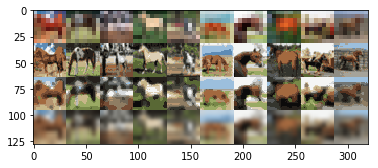

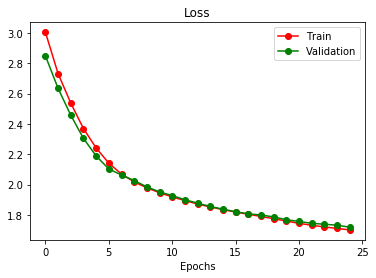

In [36]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN_SuperRes", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'super_res_unet',
              'visualize': False,
              'downsize_input':True,
}
args.update(args_dict)
sr_cnn = train(args)

(24, 3)
Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.9416, Time (s): 1
Epoch [1/25], Val Loss: 2.7161, Val Acc: 16.4%, Time(s): 2
Epoch [2/25], Loss: 2.5557, Time (s): 3
Epoch [2/25], Val Loss: 2.4064, Val Acc: 23.0%, Time(s): 4
Epoch [3/25], Loss: 2.3221, Time (s): 5
Epoch [3/25], Val Loss: 2.2487, Val Acc: 25.7%, Time(s): 6
Epoch [4/25], Loss: 2.1866, Time (s): 7
Epoch [4/25], Val Loss: 2.1412, Val Acc: 27.8%, Time(s): 8
Epoch [5/25], Loss: 2.0938, Time (s): 9
Epoch [5/25], Val Loss: 2.0556, Val Acc: 29.9%, Time(s): 10
Epoch [6/25], Loss: 2.0243, Time (s): 11
Epoch [6/25], Val Loss: 1.9977, Val Acc: 32.1%, Time(s): 12
Epoch [7/25], Loss: 1.9696, Time (s): 13
Epoch [7/25], Val Loss: 1.9476, Val Acc: 33.5%, Time(s): 14
Epoch [8/25], Loss: 1.9179, Time (s): 15
Epoch [8/25], Val Loss: 1.8856, Val Acc: 36.1%, Time(s): 16
Epoch [9/25], Loss: 1.8701, Time (s): 18
Epoch [9/25], Val Loss: 1.8462, Val Acc: 37.8%, Time(s): 18


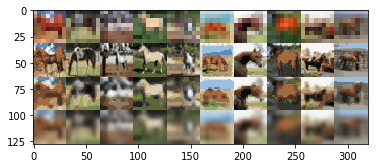

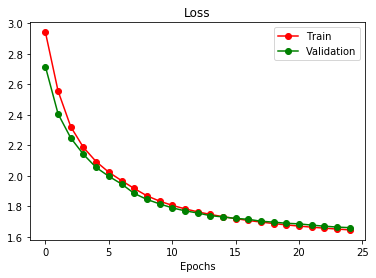

In [37]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet_SuperRes", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'super_res_unet',
              'visualize': False,
              'downsize_input':True,
}
args.update(args_dict)
sr_unet = train(args)

## 4)
## a) Input size is 8*8 as downsampling happens twice. Output image is 32X32. 4x change in resolution.
## b) We find bilinear interpolation to be blurry. Conv nets perform better than bilinear interpolation. It may be because of the fact that bilinear interolation use local information while CNN make use of globla information.
## We end up averaging during interpolation which suppresses higher frequency. Therefore we get  blurry images.

# Visualization

You will run the following code to generate visualization results. The generated images are saved in the file system of this Colab notebook. You can find them by selecting  the "Files" tab on the left side of the screen. 

>  **Files**  →   **CS6360** →   **a2**  →   **outputs**

## Visualize CNN

In [38]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_cnn',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args, cnn)

data/cifar-10-batches-py.tar.gz


(32, 16, 16) 4
(64, 8, 8) 4
(64, 8, 8) 4
(32, 16, 16) 4
visualization results are saved to outputs/colourization_cnn/act0


## 5)
## a) We observe that in the earlier layers activations resemble the shape of the image. As we move deep in the network the activations become more and more disorgansized.
## b) The Unet results differ from CNN. We observe that deeper layers of Unet preserve image structure better than CNN. The skip connections may be the reason for this.
## c) It is observed that super resoltion initially starts blurry and later give better sharper images. 

## Visualize UNet

In [39]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'colourization_unet',
              'downsize_input':False,
}
args.update(args_dict)
plot_activation(args, unet_cnn)

data/cifar-10-batches-py.tar.gz


(32, 16, 16) 4
(64, 8, 8) 4
(128, 8, 8) 4
(64, 16, 16) 4
visualization results are saved to outputs/colourization_unet/act0


## Visualize super-resolution

In [40]:
args = AttrDict()
args_dict = {
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'index':0,
              'experiment_name': 'super_res_unet',
              'downsize_input':True,
}
args.update(args_dict)
plot_activation(args, sr_cnn)

data/cifar-10-batches-py.tar.gz


(32, 16, 16) 4
(64, 8, 8) 4
(64, 8, 8) 4
(32, 16, 16) 4
visualization results are saved to outputs/super_res_unet/act0


(24, 3)
Loading data...
data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 2.5797, Time (s): 1
Epoch [1/25], Val Loss: 2.3836, Val Acc: 23.3%, Time(s): 1
Epoch [2/25], Loss: 2.1889, Time (s): 3
Epoch [2/25], Val Loss: 2.0964, Val Acc: 29.2%, Time(s): 3
Epoch [3/25], Loss: 2.0665, Time (s): 5
Epoch [3/25], Val Loss: 2.0008, Val Acc: 29.6%, Time(s): 5
Epoch [4/25], Loss: 1.9868, Time (s): 7
Epoch [4/25], Val Loss: 2.0090, Val Acc: 28.2%, Time(s): 7
Epoch [5/25], Loss: 1.9318, Time (s): 9
Epoch [5/25], Val Loss: 2.1877, Val Acc: 24.8%, Time(s): 9
Epoch [6/25], Loss: 1.8964, Time (s): 11
Epoch [6/25], Val Loss: 2.1672, Val Acc: 25.1%, Time(s): 11
Epoch [7/25], Loss: 1.8723, Time (s): 13
Epoch [7/25], Val Loss: 2.1497, Val Acc: 25.0%, Time(s): 13
Epoch [8/25], Loss: 1.8476, Time (s): 15
Epoch [8/25], Val Loss: 1.8792, Val Acc: 32.0%, Time(s): 15
Epoch [9/25], Loss: 1.8300, Time (s): 16
Epoch [9/25], Val Loss: 1.7842, Val Acc: 35.5%, Time(s): 17
E

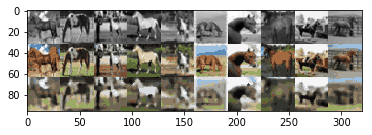

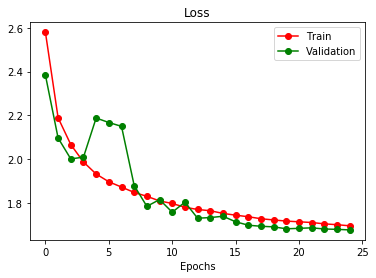

In [42]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.1, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

## 6)
## a) The five hyperparameters that can be tuned are learning rate, kernel size, number of layers, beta1 for adam and beta2 for adam. We observe that on increasing learning rate to 0.1 results get worse. The training is also not stable. Overall accuracy decreases.

## b) No difference as operators commute.

## c) Using feature level loses can help us in tackling it.Features can be extracted and then we can train using MSELoss.

## d) Reducing the image size to 32x32 -> colorizing it -> applying super resolution to get final image. This process can help in achieving the required objective.